In [17]:
"""
Grab a large‑n spatial air‑quality data‑set from OpenAQ v3.

X  →  (latitude, longitude)   – spatial predictors
y  →  pm25_concentration      – target observation (µg m⁻³)

Requires:
    pip install pandas requests tqdm
    export OPENAQ_API_KEY="..."   # free key → https://docs.openaq.org
"""
from __future__ import annotations
import os, time, requests, pandas as pd
from tqdm import tqdm

API_KEY = "eba3f9b26079e3f72fca734c7872e59379dbc0f0ab962228359db51b617807fa"
if API_KEY is None:
    raise RuntimeError(
        "Set the environment variable OPENAQ_API_KEY with your personal key."
    )

BASE   = "https://api.openaq.org/v3/parameters/2/latest"   # 2 ≡ PM2.5 ID
PAGE_SZ = 1000                                           # max rows per call

headers = {"X-API-Key": API_KEY}
params  = {"limit": PAGE_SZ, "page": 1}

records: list[dict] = []
print("Downloading PM₂.₅ ‘latest’ pages from OpenAQ …")
while True:
    resp   = requests.get(BASE, headers=headers, params=params, timeout=60)
    resp.raise_for_status()
    batch  = resp.json()["results"]              # list[dict]
    if not batch:
        break

    # Keep only rows where we have coordinates *and* a numeric reading
    for row in batch:
        coords = row.get("coordinates") or {}
        lat, lon = coords.get("latitude"), coords.get("longitude")
        val      = row.get("value")              # µg/m³
        if lat is not None and lon is not None and val is not None:
            records.append({"lat": lat, "lon": lon, "pm25": val})

    # Polite pause & advance page
    if len(batch) < PAGE_SZ:
        break
    params["page"] += 1
    time.sleep(1)                                # play nice with the API

print(f"Fetched {len(records):,} valid sensor readings")

# ---------- tidy into design matrices ----------------------------------------
df = pd.DataFrame.from_records(records)
X  = df[["lat", "lon"]].to_numpy()               # predictors
y  = df["pm25"].to_numpy()                       # response
print(df.head())


Fetched 15,348 valid sensor readings
         lat         lon  pm25
0  35.218150  128.574250   8.0
1  54.883614   23.835835  -1.0
2  40.146500  117.070900  16.0
3  37.645530 -118.966760  11.0
4  53.129419   23.108025   6.0


In [6]:
print(f"Fetched {len(records):,} valid sensor readings")

# ---------- tidy into design matrices ----------------------------------------
df = pd.DataFrame.from_records(records)
X  = df[["lat", "lon"]].to_numpy()               # predictors
y  = df["pm25"].to_numpy()                       # response
print(df.head())

Fetched 7,113 valid sensor readings
         lat         lon  pm25
0  35.218150  128.574250   8.0
1  54.883614   23.835835  -1.0
2  40.146500  117.070900  16.0
3  37.645530 -118.966760  11.0
4  53.129419   23.108025   6.0


In [19]:
X.shape

(15348, 2)

In [20]:
# Filter data to European latitudes and longitudes
# European boundaries (approximate)
europe_lat_min = 35.0   # Southern boundary (includes Mediterranean countries)
europe_lat_max = 72.0   # Northern boundary (includes Scandinavia)
europe_lon_min = -25.0  # Western boundary (includes Iceland)
europe_lon_max = 40.0   # Eastern boundary (includes parts of Russia)

# Create a mask for European coordinates
europe_mask = (
    (df['lat'] >= europe_lat_min) & 
    (df['lat'] <= europe_lat_max) & 
    (df['lon'] >= europe_lon_min) & 
    (df['lon'] <= europe_lon_max)
)

# Filter the dataframe
df_europe = df[europe_mask]

# Update X and y to use only European data
X_europe = df_europe[["lat", "lon"]].to_numpy()
y_europe = df_europe["pm25"].to_numpy()

print(f"Original data points: {len(df)}")
print(f"European data points: {len(df_europe)}")

# Use European data for further analysis
X = X_europe
y = y_europe
df = df_europe


Original data points: 15348
European data points: 3762


In [30]:
# Convert numpy arrays to PyTorch tensors and save them
import torch
import numpy as np

# Convert to torch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

# Print a sample value to verify data type
np.float64(68.4354123)

# Save tensors to .pt files
torch.save(X_torch, 'X_europe.pt')
torch.save(y_torch, 'y_europe.pt')

print(f"Saved tensors with shapes: X={X_torch.shape}, y={y_torch.shape}")


Saved tensors with shapes: X=torch.Size([3762, 2]), y=torch.Size([3762])


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_36803/511212686.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")  # plasma has higher contrast than viridis


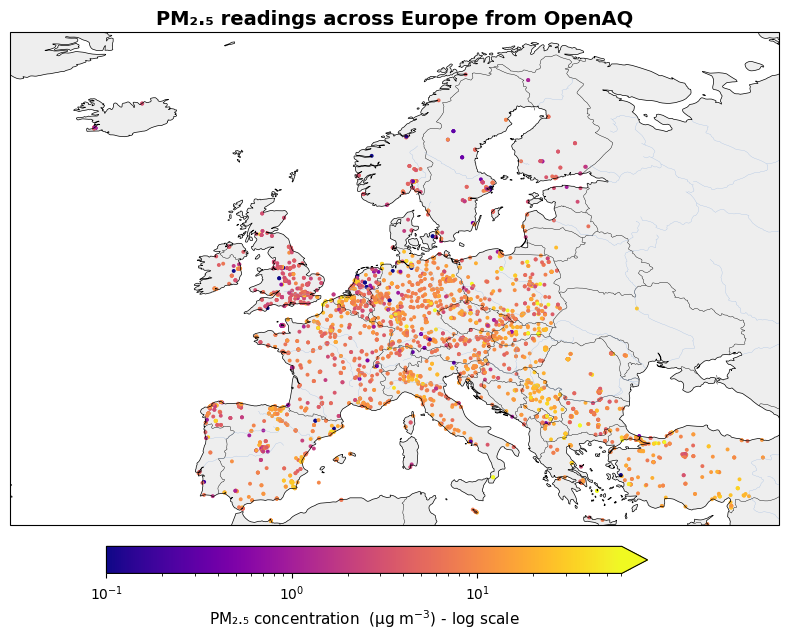

In [23]:
"""
Visualise PM2.5 readings on a European map.

$ pip install cartopy matplotlib pandas
(↳  On Ubuntu: apt-get install libproj-dev proj-data proj-bin libgeos-dev)
"""

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm
import matplotlib.cm as cm


# Optional: thin huge data sets for speed/rendering clarity
sample = df.sample(n=min(len(df), 50_000), random_state=42)
sample = df

# ---------------------------------------------------------------------
# 2.  Build the European map
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(13, 6.5))
ax = plt.axes(projection=ccrs.Robinson())

# Set map extent to European boundaries
ax.set_extent([europe_lon_min, europe_lon_max, europe_lat_min, europe_lat_max], crs=ccrs.PlateCarree())

ax.coastlines(resolution="50m", linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="#eeeeee")
ax.add_feature(cfeature.OCEAN, facecolor="#ffffff")
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.RIVERS, linewidth=0.2)

# ---------------------------------------------------------------------
# 3.  Scatter PM₂.₅ values with a high-contrast colormap on log scale
# ---------------------------------------------------------------------
# Ensure minimum value is positive for log scale
min_val = max(0.1, sample.pm25.quantile(0.01))  # Ensure positive minimum
max_val = sample.pm25.quantile(0.99)            # Clip out extreme 1% tail

norm = LogNorm(vmin=min_val, vmax=max_val)

# Using a higher contrast colormap
cmap = cm.get_cmap("plasma")  # plasma has higher contrast than viridis

sc = ax.scatter(
    sample.lon, sample.lat,
    c   = sample.pm25,
    s   = 8,                           # slightly larger marker size for Europe
    cmap=cmap, norm=norm,
    transform=ccrs.PlateCarree(),
    alpha=1.0,                         # full opacity for better visibility
    linewidths=0
)

# ---------------------------------------------------------------------
# 4.  Colour‑bar & titles
# ---------------------------------------------------------------------
cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.04,
                    fraction=0.05, extend="max")
cbar.set_label("PM₂.₅ concentration  (μg m$^{-3}$) - log scale", fontsize=11)

plt.title("PM₂.₅ readings across Europe from OpenAQ", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


In [61]:
"""
Fetch daily average temperatures (TAVG) for a custom date range via NOAA GHCN-Daily.

X  →  (latitude, longitude)   – spatial predictors
y  →  temp_c                   – daily avg. temperature in °C

Dependencies:
    pip install pandas requests
"""
import requests
import gzip, io
import pandas as pd

# ─── 1. Specify your date window here ───────────────────────────────────────
# One-day example:
# start_date = "2024-01-15"
# end_date   = "2024-01-15"
#
# One-week example:
start_date = "2024-01-01"
end_date   = "2024-01-02"
# ────────────────────────────────────────────────────────────────────────────

# Parse year(s) you’ll need
yr_start = pd.to_datetime(start_date).year
yr_end   = pd.to_datetime(end_date).year

# 2. Load station metadata
stations_url = "https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
r = requests.get(stations_url, timeout=60); r.raise_for_status()
fwf_cols = [(0,11), (12,20), (21,30)]
stations = pd.read_fwf(
    io.StringIO(r.text),
    colspecs=fwf_cols,
    names=["id","lat","lon"],
    usecols=["id","lat","lon"]
)

# 3. Stream each year’s file, filter to TAVG in your window
col_names = ["id","date","element","value","mflag","qflag","sflag","time"]
chunks = []
for year in range(yr_start, yr_end + 1):
    data_url = f"https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/{year}.csv.gz"
    r = requests.get(data_url, stream=True, timeout=120); r.raise_for_status()
    gz = gzip.GzipFile(fileobj=io.BytesIO(r.content))

    for chunk in pd.read_csv(gz, names=col_names, header=None, chunksize=500_000):
        # Convert date column from integer to string format for comparison
        chunk['date'] = chunk['date'].astype(str)
        # Format dates as YYYY-MM-DD for comparison
        chunk['date'] = pd.to_datetime(chunk['date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
        
        m = (
            (chunk.element == "TAVG") &
            (chunk.date >= start_date) & (chunk.date <= end_date)
        )
        if m.any():
            chunks.append(chunk.loc[m, ["id","date","value"]])

# 4. Concatenate & clean up
if not chunks:
    raise RuntimeError(f"No TAVG data found from {start_date} to {end_date}")
df = pd.concat(chunks, ignore_index=True)
df["date"]   = pd.to_datetime(df["date"])
df["temp_c"] = df["value"] / 10.0    # tenths of °C → °C

# 5. Merge lat/lon
df = df.merge(stations, on="id", how="left")

# 6. Build design matrices
X = df


In [63]:
df

,id,date,value,temp_c,lat,lon
0,USC00244558,2024-01-01,-14,-1.4,48.3042,-114.2642
1,USR0000AALP,2024-01-01,-12,-1.2,33.8417,-109.1222
2,USR0000AASI,2024-01-01,-88,-8.8,67.4750,-162.2664
3,USR0000ABAN,2024-01-01,27,2.7,34.1400,-87.3622
4,USR0000ABCK,2024-01-01,-334,-33.4,65.5847,-144.3636
...,...,...,...,...,...,...
12391,VMM00048845,2024-01-02,223,22.3,18.7370,105.6710
12392,VMM00048848,2024-01-02,224,22.4,17.4830,106.6000
12393,VMM00048855,2024-01-02,228,22.8,16.0440,108.1990
12394,VMM00048887,2024-01-02,273,27.3,10.9330,108.1000


In [66]:
# Create a new dataframe with only USA data
# USA latitude range: approximately 24.5°N to 49.5°N
# USA longitude range: approximately -125°W to -66.5°W
usa_df = df[(df['lat'] >= 24.5) & (df['lat'] <= 49.5) & 
            (df['lon'] >= -125) & (df['lon'] <= -66.5)]

# Display the shape of the USA dataframe
print(f"Original dataframe shape: {df.shape}")
print(f"USA dataframe shape: {usa_df.shape}")

# Preview the USA dataframe
usa_df.head()


Original dataframe shape: (12396, 6)
USA dataframe shape: (4766, 6)


,id,date,value,temp_c,lat,lon
0,USC00244558,2024-01-01,-14,-1.4,48.3042,-114.2642
1,USR0000AALP,2024-01-01,-12,-1.2,33.8417,-109.1222
3,USR0000ABAN,2024-01-01,27,2.7,34.1400,-87.3622
6,USR0000ABLA,2024-01-01,64,6.4,33.0867,-109.9506
7,USR0000ABNS,2024-01-01,137,13.7,30.2528,-87.8125


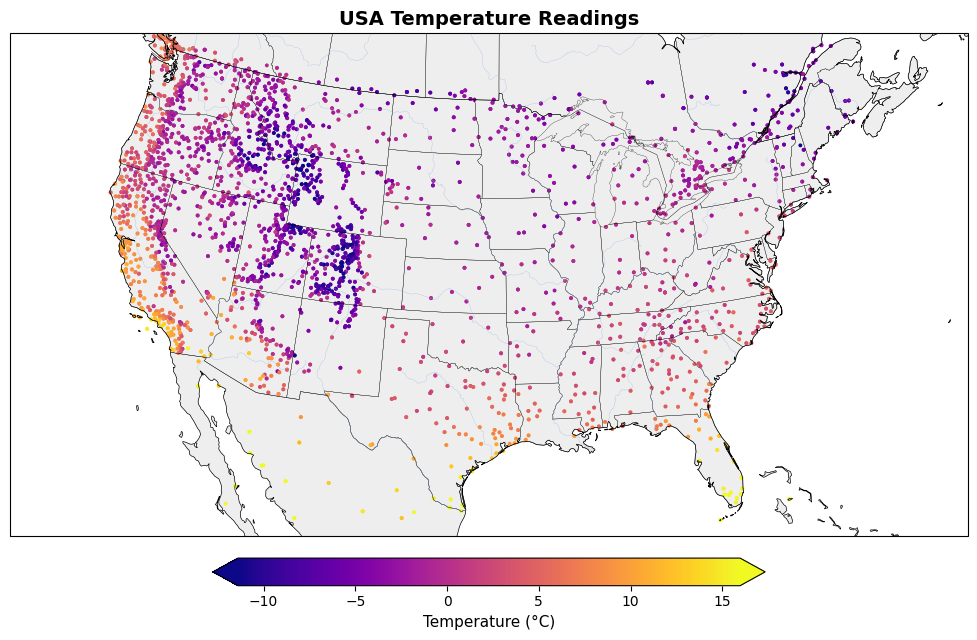

In [68]:
"""
Visualise temperature readings on a USA map.

$ pip install cartopy matplotlib pandas
(↳  On Ubuntu: apt-get install libproj-dev proj-data proj-bin libgeos-dev)
"""

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm


# Use the USA filtered data
sample = usa_df

# ---------------------------------------------------------------------
# 2.  Build the USA map
# ---------------------------------------------------------------------
fig = plt.figure(figsize=(13, 6.5))
ax = plt.axes(projection=ccrs.LambertConformal(
    central_longitude=-95, central_latitude=35))

# Set map extent to cover continental USA
ax.set_extent([-125, -66.5, 24.5, 49.5], crs=ccrs.PlateCarree())

ax.coastlines(resolution="50m", linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="#eeeeee")
ax.add_feature(cfeature.OCEAN, facecolor="#ffffff")
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)
ax.add_feature(cfeature.RIVERS, linewidth=0.2)

# ---------------------------------------------------------------------
# 3.  Scatter temperature values with a high-contrast colormap
# ---------------------------------------------------------------------
# Get temperature range for colormap
min_val = sample.temp_c.quantile(0.01)  # Lower bound
max_val = sample.temp_c.quantile(0.99)  # Upper bound, clip out extreme 1% tail

# Using a higher contrast colormap
cmap = cm.get_cmap("plasma")  # plasma has higher contrast than viridis

sc = ax.scatter(
    sample.lon, sample.lat,
    c   = sample.temp_c,
    s   = 8,                           # marker size
    cmap=cmap, vmin=min_val, vmax=max_val,
    transform=ccrs.PlateCarree(),
    alpha=1.0,                         # full opacity for better visibility
    linewidths=0
)

# ---------------------------------------------------------------------
# 4.  Colour‑bar & titles
# ---------------------------------------------------------------------
cbar = fig.colorbar(sc, ax=ax, orientation="horizontal", pad=0.04,
                    fraction=0.05, extend="both")
cbar.set_label("Temperature (°C)", fontsize=11)

plt.title("USA Temperature Readings", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


In [72]:
# Save world temperature data as a PyTorch tensor
import torch

# Extract the relevant columns
lats = torch.tensor(df['lat'].values, dtype=torch.float32)
lons = torch.tensor(df['lon'].values, dtype=torch.float32)
temps = torch.tensor(df['temp_c'].values, dtype=torch.float32)

# Create input features (x) by stacking latitude and longitude
x = torch.stack([lats, lons], dim=1)  # Shape: [n_samples, 2]

# Target values (y) are the temperatures
y = temps  # Shape: [n_samples]

# Save the tensors
torch.save({'x': x, 'y': y}, 'world_temp_data.pt')

print(f"Saved tensor data with {x.shape[0]} samples")
print(f"x shape: {x.shape}, y shape: {y.shape}")


Saved tensor data with 12396 samples
x shape: torch.Size([12396, 2]), y shape: torch.Size([12396])


In [65]:
df.shape

(12396, 6)